# Load

## Libraries

In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.colors import ListedColormap

import geopandas as gpd
import shapely

## Data

### Provincias

In [2]:
with open('Provincias.txt') as fh:
    filecont=fh.readlines()

In [3]:
provincia=[]
for line in filecont:
    current=line[:-1]
    provincia.append(current)

### Resultados

In [4]:
Resultado={}
for prov in provincia:
    Resultado[prov]=pd.read_csv('Resultados/'+prov+'.csv',index_col=[0],usecols=['Candidaturas','Votos'])

### Escaños

In [5]:
with open('Diputados.txt') as fh:
    filecont=fh.readlines()

In [6]:
Diputados={}
for line in filecont:
    key,val=line.split(sep=': ')
    Diputados[key]=pd.to_numeric(val[:-1])

# Funciones

## Calculador de Escaños

In [7]:
def CalcularDiputados(Res,Dips):
    div=np.array([1/i for i in range(1,Dips+1)])
    df=Res['Votos'].apply(lambda x: x*div).apply(pd.Series).unstack().sort_values(ascending=False)[:Dips]
    x=df.index.get_level_values(1).value_counts()
    return x

## Calcular Parlamento

### Indice Partidos

In [8]:
def Partidos(Res):
    ind=pd.Index(['PP'])
    for prov in Res:
        ind=ind.union(Res[prov].index)
    return ind

### Composicion Parlamentaria

In [9]:
def Parlamento(Res):
    Part=Partidos(Res)
    df=pd.DataFrame(data=Res,index=Part,dtype=int).replace(np.nan,0)
    return df.assign(Total=df.sum(axis=1))

## Partido Mas Votado

In [41]:
def MasVotado(Res,provincia):
    df=pd.DataFrame(data=provincia,index=provincia)
    for prov in provincia:
        df.loc[prov]=Res[prov].sort_values(by='Votos',ascending=False).index[0]
    return df

## Elecciones

In [25]:
def Elecciones(Provincia, Votos, Dip):
    
    Elecciones={}
    ResDip={}
    for prov in Provincia:
        ResDip[prov]=CalcularDiputados(Votos[prov],Diputados[prov])
        
    Elecciones['Parlamento']=Parlamento(ResDip)
    Elecciones['Circunscripcion']=MasVotado(Votos,Provincia)
    Elecciones['Votos']=Votos
    
    return Elecciones

# Visualizacion

## Mapa

### Diccionario Nombres

In [12]:
def DicNombres():
    
    mapdict={
    'CÃ¡ceres': 'Caceres',
    'LÃ©rida': 'Lleida',
    'Gerona': 'Girona',
    'Orense': 'Oursense',
    'CÃ¡diz': 'Cadiz',
    'CastellÃ³n': 'Castellon',
    'AlmerÃ­a': 'Almeria',
    'MÃ¡laga': 'Malaga',
    'La CoruÃ±a': 'A Coruna',
    'Santa Cruz de Tenerife': 'Tenerife',
    'Baleares': 'Illes Balears',
    'Ãlava': 'Alava',
    'LeÃ³n': 'Leon',
    'Ãvila': 'Avila',
    'CÃ³rdoba': 'Cordoba',
    'JaÃ©n': 'Jaen'
    }
    
    return mapdict

### Color Map

In [13]:
def CreateColorMap():
    
    colormap=cm.get_cmap('Blues',5)(np.linspace(0,1,5))
    
    colormap[0]=[243/256,178/256,23/256,1]
    colormap[1]=[201/256,28/256,41/256,1]
    colormap[2]=[0/256,149/256,38/256,1]
    colormap[3]=[0/256,85/256,167/256,1]
    colormap[4]=[237/256,28/256,36/256,1]
    
    return ListedColormap(colormap)

### Mover Canarias

In [63]:
def MoverCanarias(Geo,x=0,y=0):
    
    for i in esp.loc[esp['adm0_sr']==3].index:
        Geo['geometry'].loc[i]=shapely.affinity.translate(esp['geometry'].loc[i], xoff=x, yoff=y)
    
    return Geo

### Mapa

In [212]:
def Mapa(Res,text=''):
    
    map_df=gpd.read_file('Map/ne_10m_admin_1_states_provinces.shp')
    spa=map_df.loc[map_df['iso_a2']=='ES']
    
    esp=MoverCanarias(spa)
    
    mapdict=DicNombres()
    
    esp['prov']=esp['name'].replace(mapdict)
    
    merge=esp.set_index('prov').join(Res['Circunscripcion'])
    
    colormap=CreateColorMap()
    
    plt.rcParams.update({'font.size':32})

    ax=merge.plot(column=0,cmap=colormap,figsize=(31,19),linewidth=0.8,edgecolor='0.8',legend=True,categorical=True)
    ax.set_axis_off()
    ax.set_title('Ganador por Circunscripcion'+text)
    plt.show()

## Parlamento

### Create Labels

In [16]:
def CreateLabels(Parl,Limite=6):
    
    label=list(Parl.index)
    
    for i,v in enumerate(label):
        if Parl[v]<Limite:
            label[i]=''
    
    return label

### Display Escaños

In [17]:
def disp(pct):
    if pct>1.5:
        return '{:.0f}'.format(pct*3.5)

### Create Colors

In [18]:
def CreateColors(Partidos):
    
    PartyColors={
        'PSOE':'#ED1C24',
        'PP': '#0055A7',
        'Cs': '#FA5000',
        'Podemos': '#6A2E68',
        'VOX': '#5AC035',
        'ERC': '#F3B217',
        'JxCAT': '#C40048',
        'PNV': '#009526',
        'EH Bildu': '#A3C940',
        'NA+': '#FFDA1A',
        'CC': '#E51C13',
        'PRC': '#DB6426',
        'COMPROMÍS': '#BECD48'
    }
    
    return Partidos.map(PartyColors).values

### Composicion

In [213]:
def Composicion(Res,text=''):
    
    sortedparl=Res['Parlamento'].Total.sort_values(ascending=False)
    
    label=CreateLabels(sortedparl)
    
    colors=CreateColors(sortedparl.index)
    
    plt.rcParams.update({'font.size':12})

    plt.figure(figsize=(10,10))
    plt.pie(sortedparl,colors=colors,wedgeprops=dict(width=0.5),startangle=90,labels=label,autopct=lambda x: disp(x),pctdistance=0.75,textprops={'fontsize':'large','weight':'bold'})
    plt.title('Composicion del Parlamento'+text,fontdict={'fontsize':32})
    plt.show()

# Cambio Electoral

## Nuevo Resultado

In [20]:
def NuevoResultado(Res,Part1,Part2,Peso=1):
    NRes=Res.copy()
    if np.isin('NA+',NRes.index) & ((Part1=='PP') | (Part1=='Cs')):
        Part1='NA+'
    if np.isin(Part1,NRes.index) & np.isin(Part2,NRes.index):
        NRes.loc[Part1]=NRes.loc[Part1]+(NRes.loc[Part2]*Peso)
        NRes.loc[Part2]=NRes.loc[Part2]*(1-Peso)
    return NRes

## Nuevas Elecciones

In [21]:
def NuevasElecciones(Provincia, Votos, Diputados, Partido1, Partido2, Peso=1):
    
    NVotos={}
    NVotos['Partido1']=Partido1
    NVotos['Partido2']=Partido2
    NVotos['Peso']=Peso
    for prov in Provincia:
        NVotos[prov]=NuevoResultado(Votos[prov],Partido1, Partido2, Peso)
    
    return Elecciones(Provincia, NVotos, Diputados)

# Diferencia

In [270]:
def Diferencia(Res,NRes):
    
    Opc1=Res['Parlamento'].Total.sort_values(ascending=False)
    Opc2=NRes['Parlamento'].Total.sort_values(ascending=False)
    
    Partido1=NRes['Votos']['Partido1']
    Partido2=NRes['Votos']['Partido2']
    Peso=NRes['Votos']['Peso']
    
    DCH=['PP','VOX','Cs']
    IZQ=['PSOE','Podemos']
    
    Newid=Opc1.index.intersection(Opc2.index)
    
    colors=CreateColors(Newid)
    
    dif=Opc2-Opc1
    order=abs(dif.loc[(dif!=0) & dif.notna()]).sort_values(ascending=False)
    
    fig, ax=plt.subplots()

    plt.rcParams.update({'font.size':32})
    
    ind=np.arange(len(Newid))
    width=0.35
    fig.set_size_inches(31,19)
    
    locP1=ind[Newid==Partido1][0]
    
    p1 = ax.bar(ind,Opc1[Newid],width,color=colors)
    p2 = ax.bar(ind+width,Opc2[Newid],width,color=colors,alpha=0.5)
    
    if NRes['Votos']['Peso']==1:
        dif.loc[Partido1]=dif.loc[Partido1]-Opc1.loc[Partido2]
        Miss=Opc1.index.difference(Newid)
        color1=CreateColors(Miss)
        p3 = ax.bar(locP1,Opc1[Miss],width,color=color1,bottom=Opc1.iloc[locP1])
        ax.legend((p1[locP1],p2[locP1]),('{0:s} y {1:s} Separados'.format(Partido1,Partido2),'{0:s} + {1:s}'.format(Partido1,Partido2)))
    else:
        ax.legend((p1[locP1],p2[locP1]),('{0:s} y {1:s} Separados'.format(Partido1,Partido2),'{0:s} + {2:2.0f}% {1:s}'.format(Partido1,Partido2,Peso*100)))
    
    order=abs(dif.loc[(dif!=0) & dif.notna()]).sort_values(ascending=False)
    
    ax.set_title('Resultado de las elecciones si el {2:2.0f}% del voto de {1:s} fuera al {0:s}'.format(Partido1,Partido2,Peso*100))
    ax.set_xticks(ind+width/2)
    ax.set_xticklabels(Newid)
    
    ax.text(6,60,u'Diferencia:\n\n'+'\n'.join('{:10s}{:+.0f}'.format(i,dif.loc[i]) for i in order.index),family='monospace')
    ax.text(9,60,u'Bloque Derecha:   {:+.0f}\nBloque Izquierda: {:+.0f}'.format(dif.loc[dif.index.isin(DCH)].sum(),dif.loc[dif.index.isin(IZQ)].sum()),family='monospace')
    for i in ind:
        ax.text(i+width*0.6,Opc2[Newid[i]]+5,'{:.0f}'.format(Opc2[Newid[i]]))
    plt.show()

In [246]:
DCH=['PP','VOX','Cs']

In [250]:
dif.loc[dif.index.isin(DCH)].sum()

43.0

# PP y Vox

In [196]:
Res1=Elecciones(provincia, Resultado, Diputados)

In [259]:
Res2=NuevasElecciones(provincia, Resultado, Diputados, 'PP', 'VOX',1)

C:\ProgramData\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


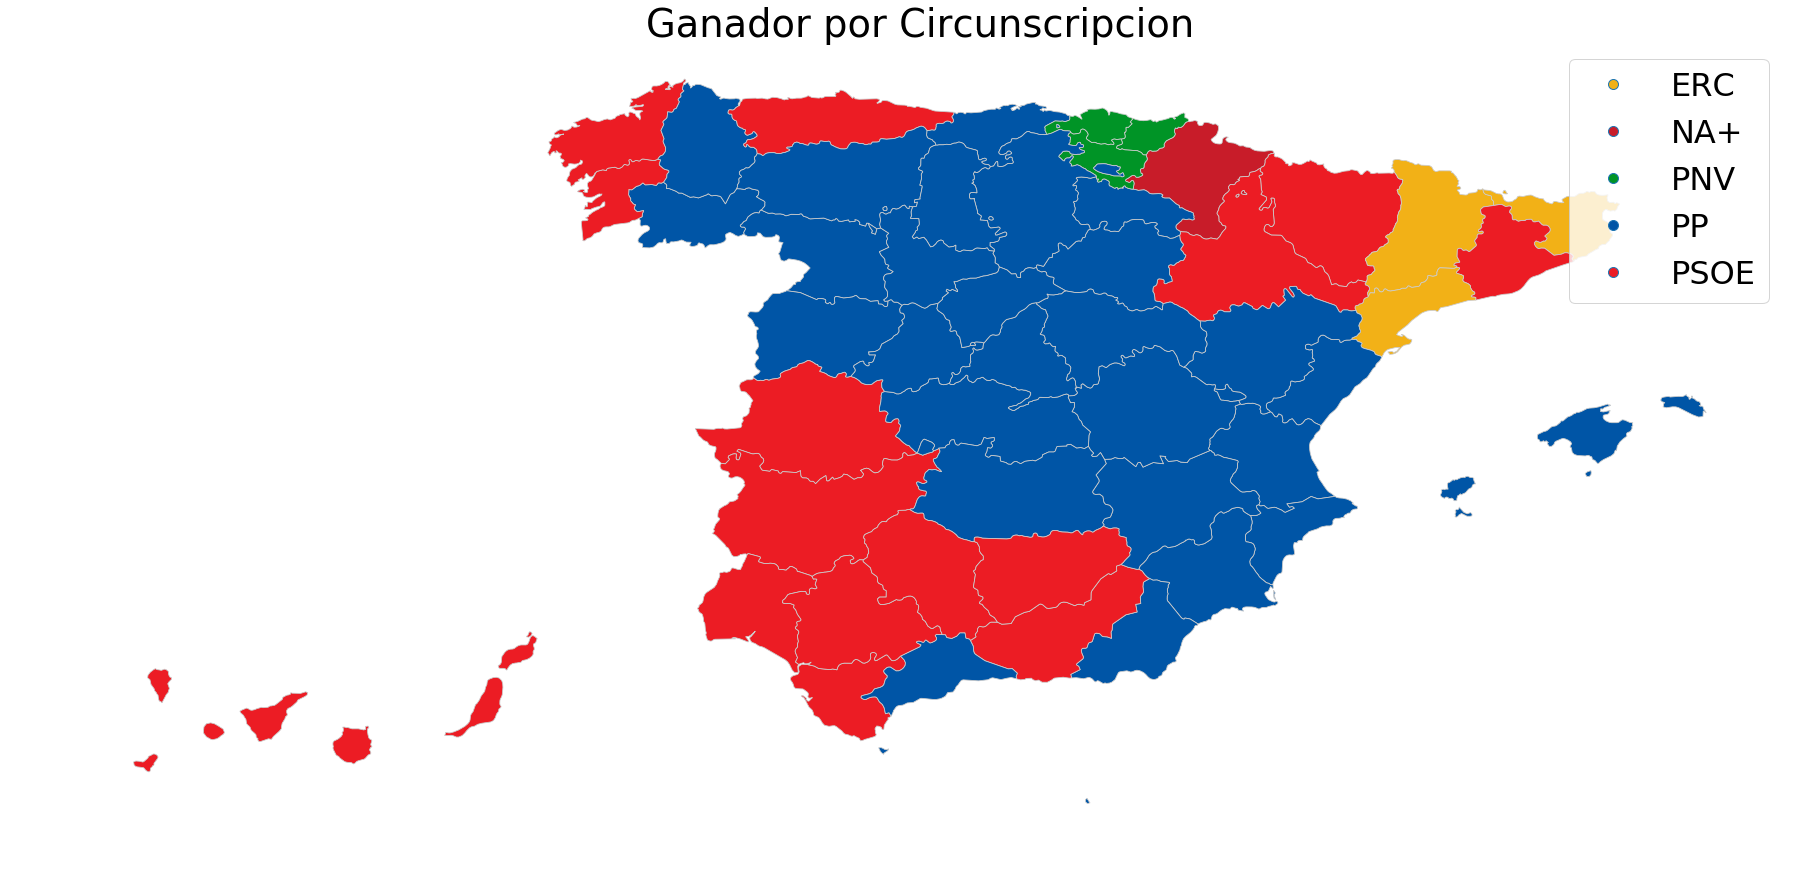

In [260]:
Mapa(Res2)

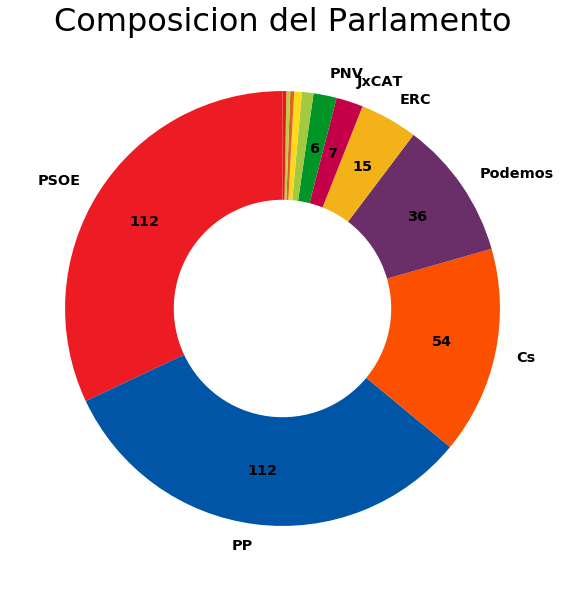

In [261]:
Composicion(Res2)

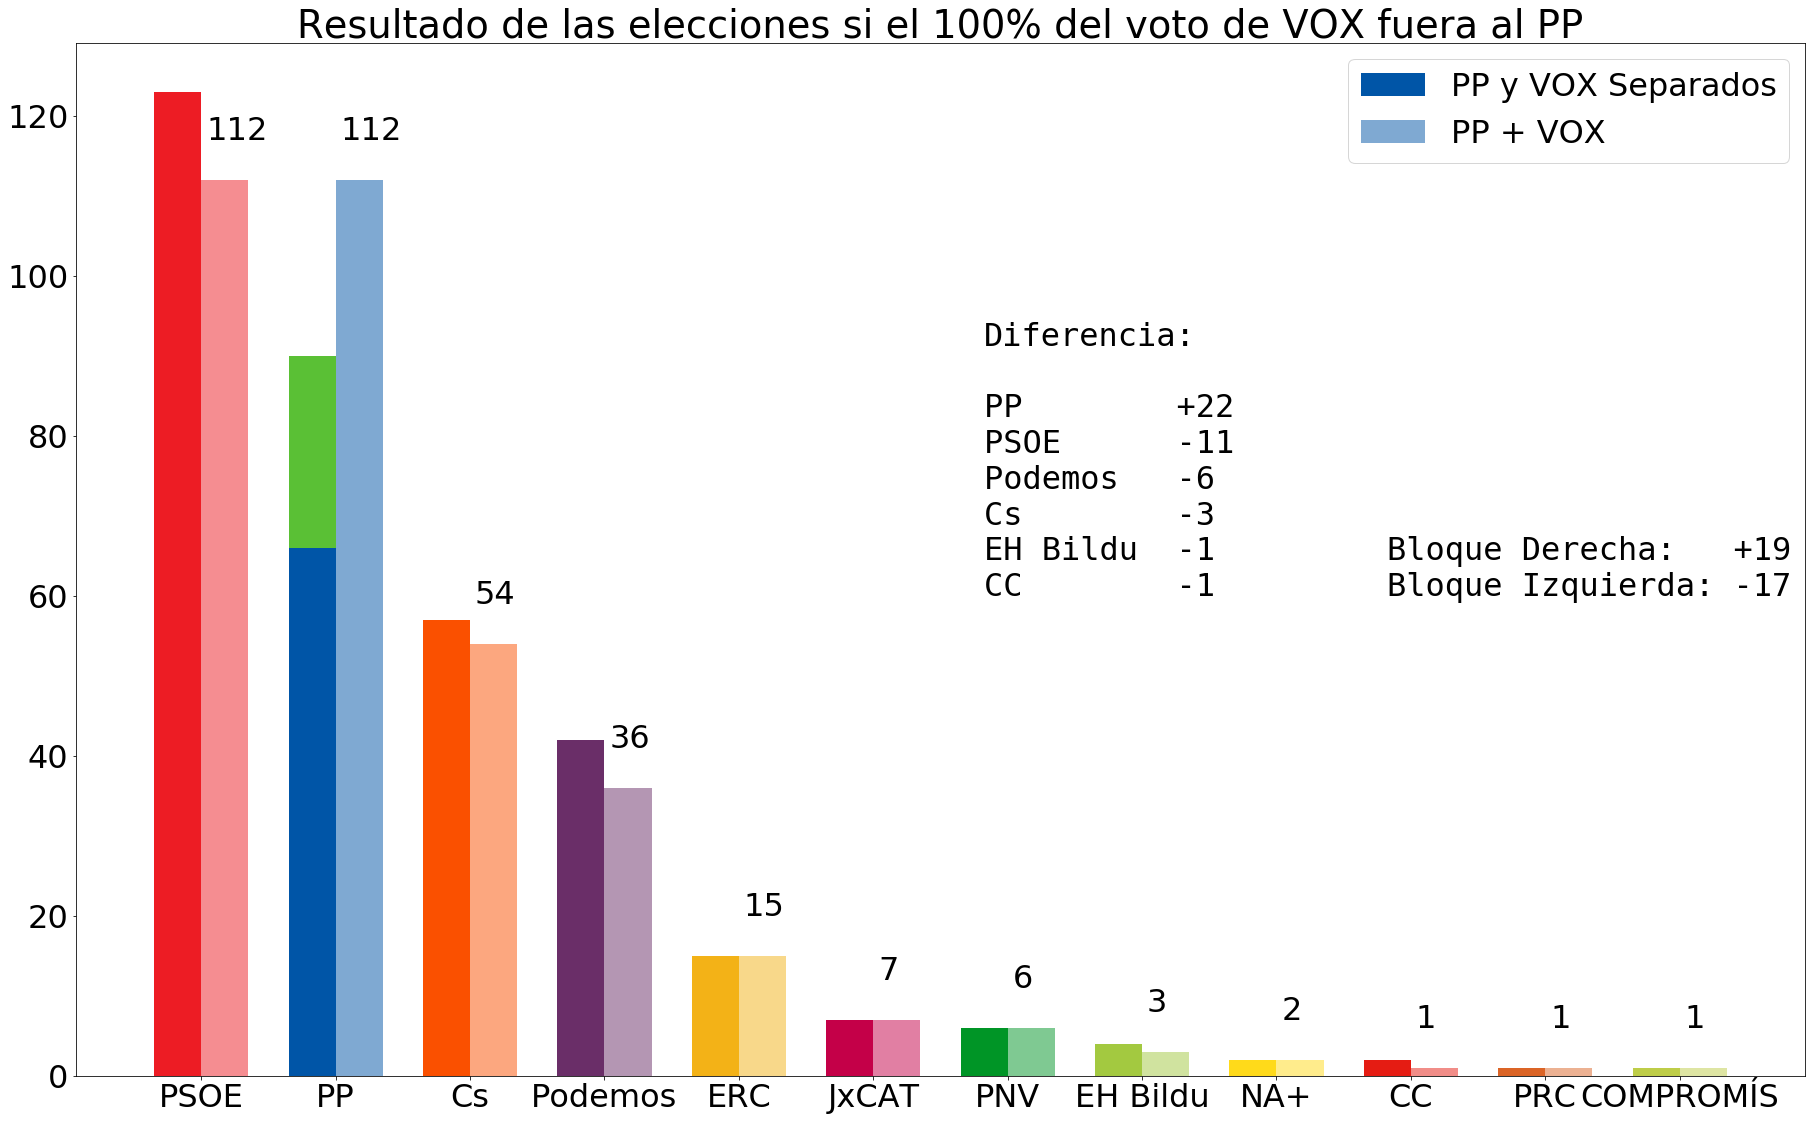

In [271]:
Diferencia (Res1,Res2)

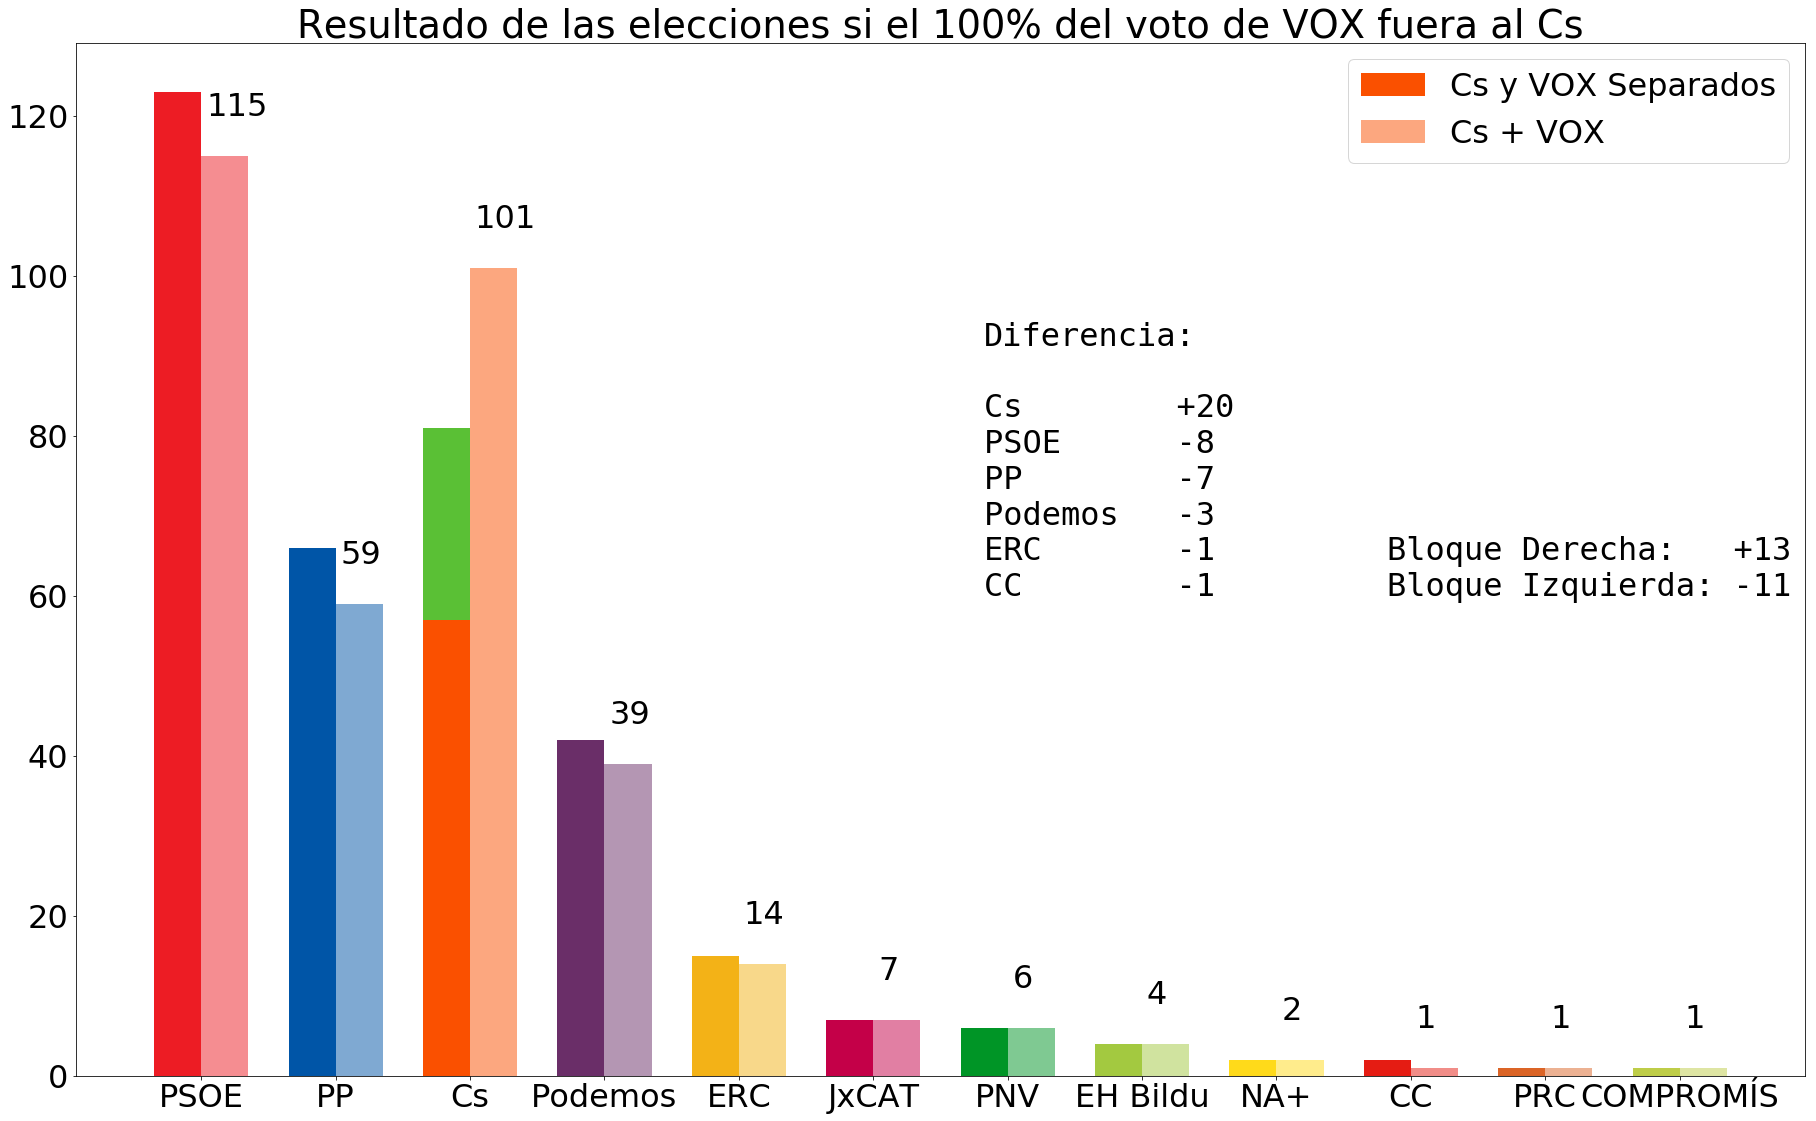

In [273]:
Diferencia(Elecciones(provincia, Resultado, Diputados),NuevasElecciones(provincia, Resultado, Diputados, 'Cs', 'VOX',1))